# Word Analysis
Analyse the articles by word counts, word importances and other features!

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
# Add functions path
import sys
sys.path.append('../../Functions')
from datasets import load_stratified_dataset
from sklearn.cluster import KMeans
%matplotlib inline

#### Load dataset

In [2]:
df = load_stratified_dataset(path='../../Datasets/dataset_categories/dataset_categories_train.csv', labels='category', samples_per_label=100)

***
## Naive Bayes for word importances

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

text = df.text_lem.values
# Number of times the words have to occur at least
min_df=10

# ngram_range only use 1 word, stop_words=english remove common words(eg: a, an, the)
# CountVectorizer ignores difference between lower and upper case and puncuation
vect = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=min_df)

# CountVectorizer converts list of strings to matrix with: rows = observation, columns = terms in text, values=count/document
X = vect.fit_transform(text)
words = vect.get_feature_names()


# Turn result to dummies, so that columns are in correct order
d = {}
count=0
for i in df.category.unique():
    d[i] = count
    count += 1
df['category_num'] = [d[i] for i in df.category]

y = df.category_num

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

likelihood_df_raw = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=df.category.unique(), index=words)

In [4]:
likelihood = {}
for category in df.category.unique():
    likelihood[category] = np.exp(likelihood_df_raw[category]) - np.sum(np.exp(likelihood_df_raw.drop(category, axis=1)), axis=1)
    #likelihood_df[category] = np.exp(likelihood_df_raw[category]) - np.exp(np.sum(likelihood_df_raw.drop(category, axis=1), axis=1))
    
    # Sort likelihood
    likelihood[category] = likelihood[category].sort_values(ascending=False)
    
likelihood_df = pd.DataFrame(likelihood)

***
## Most used words

In [5]:
count_total = dict(zip(words, X.toarray().sum(axis=0)))

***
## Word count per category

In [6]:
# Create list containing empty list for each category
l = [[] for i in df.category.unique()]
ct = 1
total = y.shape[0]
# Append vectors depending on their category
for category, count in zip(y, X.toarray()):
    print('Get vectors for each category: {:.2f}%'.format(ct/total*100), end='\r')
    ct+=1
    l[category].append(count)

In [7]:
l2 = []
count=1
# Get the sum of counts for each category
for cat in l:
    print('Count words for each category: {:.2f}%'.format(count/len(l)*100), end='\r')
    count+=1
    cat = np.array(cat)
    tmp = cat.sum(axis=0)
    l2.append(tmp)
    
l2 = np.array(l2)

In [8]:
# Transform counts in Dataframe
word_count = pd.DataFrame(l2.transpose(), columns=df.category.unique(), index=words)

***
## Choose Vocabulary

In [9]:
if True:
    vocab_size = 30

    # Get vocabulary
    vocabulary = set()
    for category in likelihood.keys():
        vocabulary.update(likelihood[category].index[:vocab_size])
    vocabulary = list(vocabulary)
else:
    vocabulary = words
    
#vocabulary

***
## Create Force Field

In [10]:
# X(articles, word_count); y(category); words(words)
X.toarray().shape, y.shape, np.array(words).shape

((700, 1943), (700,), (1943,))

In [11]:
# Get words, Distribution of words over articles
words = np.array(words)
Distribution = X.toarray()

In [12]:
# Only select vocabulary
mask = [True if word in vocabulary else False for word in words]
Distribution = Distribution[:,mask]
words = words[mask]

In [13]:
# Map and Map history over iterations
Map_History = []

# Initialize Map randomly
Map = np.random.randn(words.shape[0], 2)*5
Map_History.append(Map.copy())

In [18]:
# Calculate attraction/repulsion
# The more often the word appears, the higher the attraction/repulsion
min_att, max_att = 1, 10
        
l = []
for word in words:
    l.append(count_total[word])
min_count = min(l)
max_count = max(l)
        
m = (max_count - min_count)/(max_att - min_att)
b = min_count - max_count/m

force_per_word = [(count_total[word]/m+b) for word in words]

In [15]:
# Calculate euclidian distance between objects
def calc_dist_vec(word1, word2):
    p1 = Map[word1]
    p2 = Map[word2]
    
    vec = p1-p2
    dist = np.linalg.norm(vec)
    #dist = np.square(np.square(p1-p2).sum())
    
    return dist, vec/dist

In [16]:
# Calculate Interaction between two words
# Words attract each other for each equal article
def interaction(word1, word2):    
    # Get distribution in articles of both words
    dist1 = Distribution[:, word1]
    dist2 = Distribution[:, word2]

    # Get number of articles the words share
    matches = ((dist1 > 0) & (dist2 > 0)).sum()

    # Get distance between words
    dist, vec = calc_dist_vec(word1, word2)
    
    # Calculate force (include small value because of start point)
    num_articles = Distribution.shape[0]
    f1 = force_per_word[word1]
    f2 = force_per_word[word2]
    att_force = 100 * f1*f2 * matches / (dist + 0.01) / num_articles
    rep_force = 100 * f1*f2 * (num_articles - matches) / (dist + 0.01)**2 / num_articles
    #print(opp_force)

    # Add force to move
    Move[word1, :] -= vec*(att_force - rep_force)
    Move[word2, :] += vec*(att_force - rep_force)

In [17]:
# Clip Movement if too large
def clip():
    for i in range(Move.shape[0]):
        dist = np.linalg.norm(Move[i,:])
        if abs(dist) > 3:
            Move[i,:] = Move[i,:]/dist * 3

In [18]:
# Iterate x times
for it in range(3000):
    start_time = time()
    # Set Move to zero
    Move = np.zeros([words.shape[0], 2])
    # Run all words over all words

    for word1 in range(words.shape[0]):
        for word2 in range(word1+1, words.shape[0]):

            # Calculate interaction
            interaction(word1, word2)

    # Clip Movement
    clip()
    # Update Map
    Map += Move
    Map_History.append(Map.copy())

    print('Iteration {} finished in {:.2f}m'.format(it+1, (time()-start_time)/60), end='\r')

In [19]:
with open('Map_History.pickle', 'wb') as file:
    pickle.dump(Map_History, file, protocol=pickle.HIGHEST_PROTOCOL)

***
## Give Words Categories
Give word the category where it has most occurences.

In [20]:
#word_categories = [word_count.loc[word].argmax() for word in words]

In [21]:
word_categories = [likelihood_df.loc[word].argmax() if likelihood_df.loc[word].max() > 0 else 7 for word in words]

In [22]:
#word_categories

***
## Sizes of markers
Create scaler to get sizes of markers between a range.

In [23]:
min_size, max_size = 30, 80

In [24]:
class Scaler():
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size
        
    def fit(self, words, count_total):
        l = []
        for word in words:
            l.append(count_total[word])
        min_count = min(l)
        max_count = max(l)
        
        self.m = (max_count - min_count)/(max_size - min_size)
        self.b = 60 - max_count/self.m
        
    def transform(self, x):
        
        return x/self.m + self.b

In [25]:
scaler = Scaler(min_size, max_size)
scaler.fit(words, count_total)

***
## Create plot

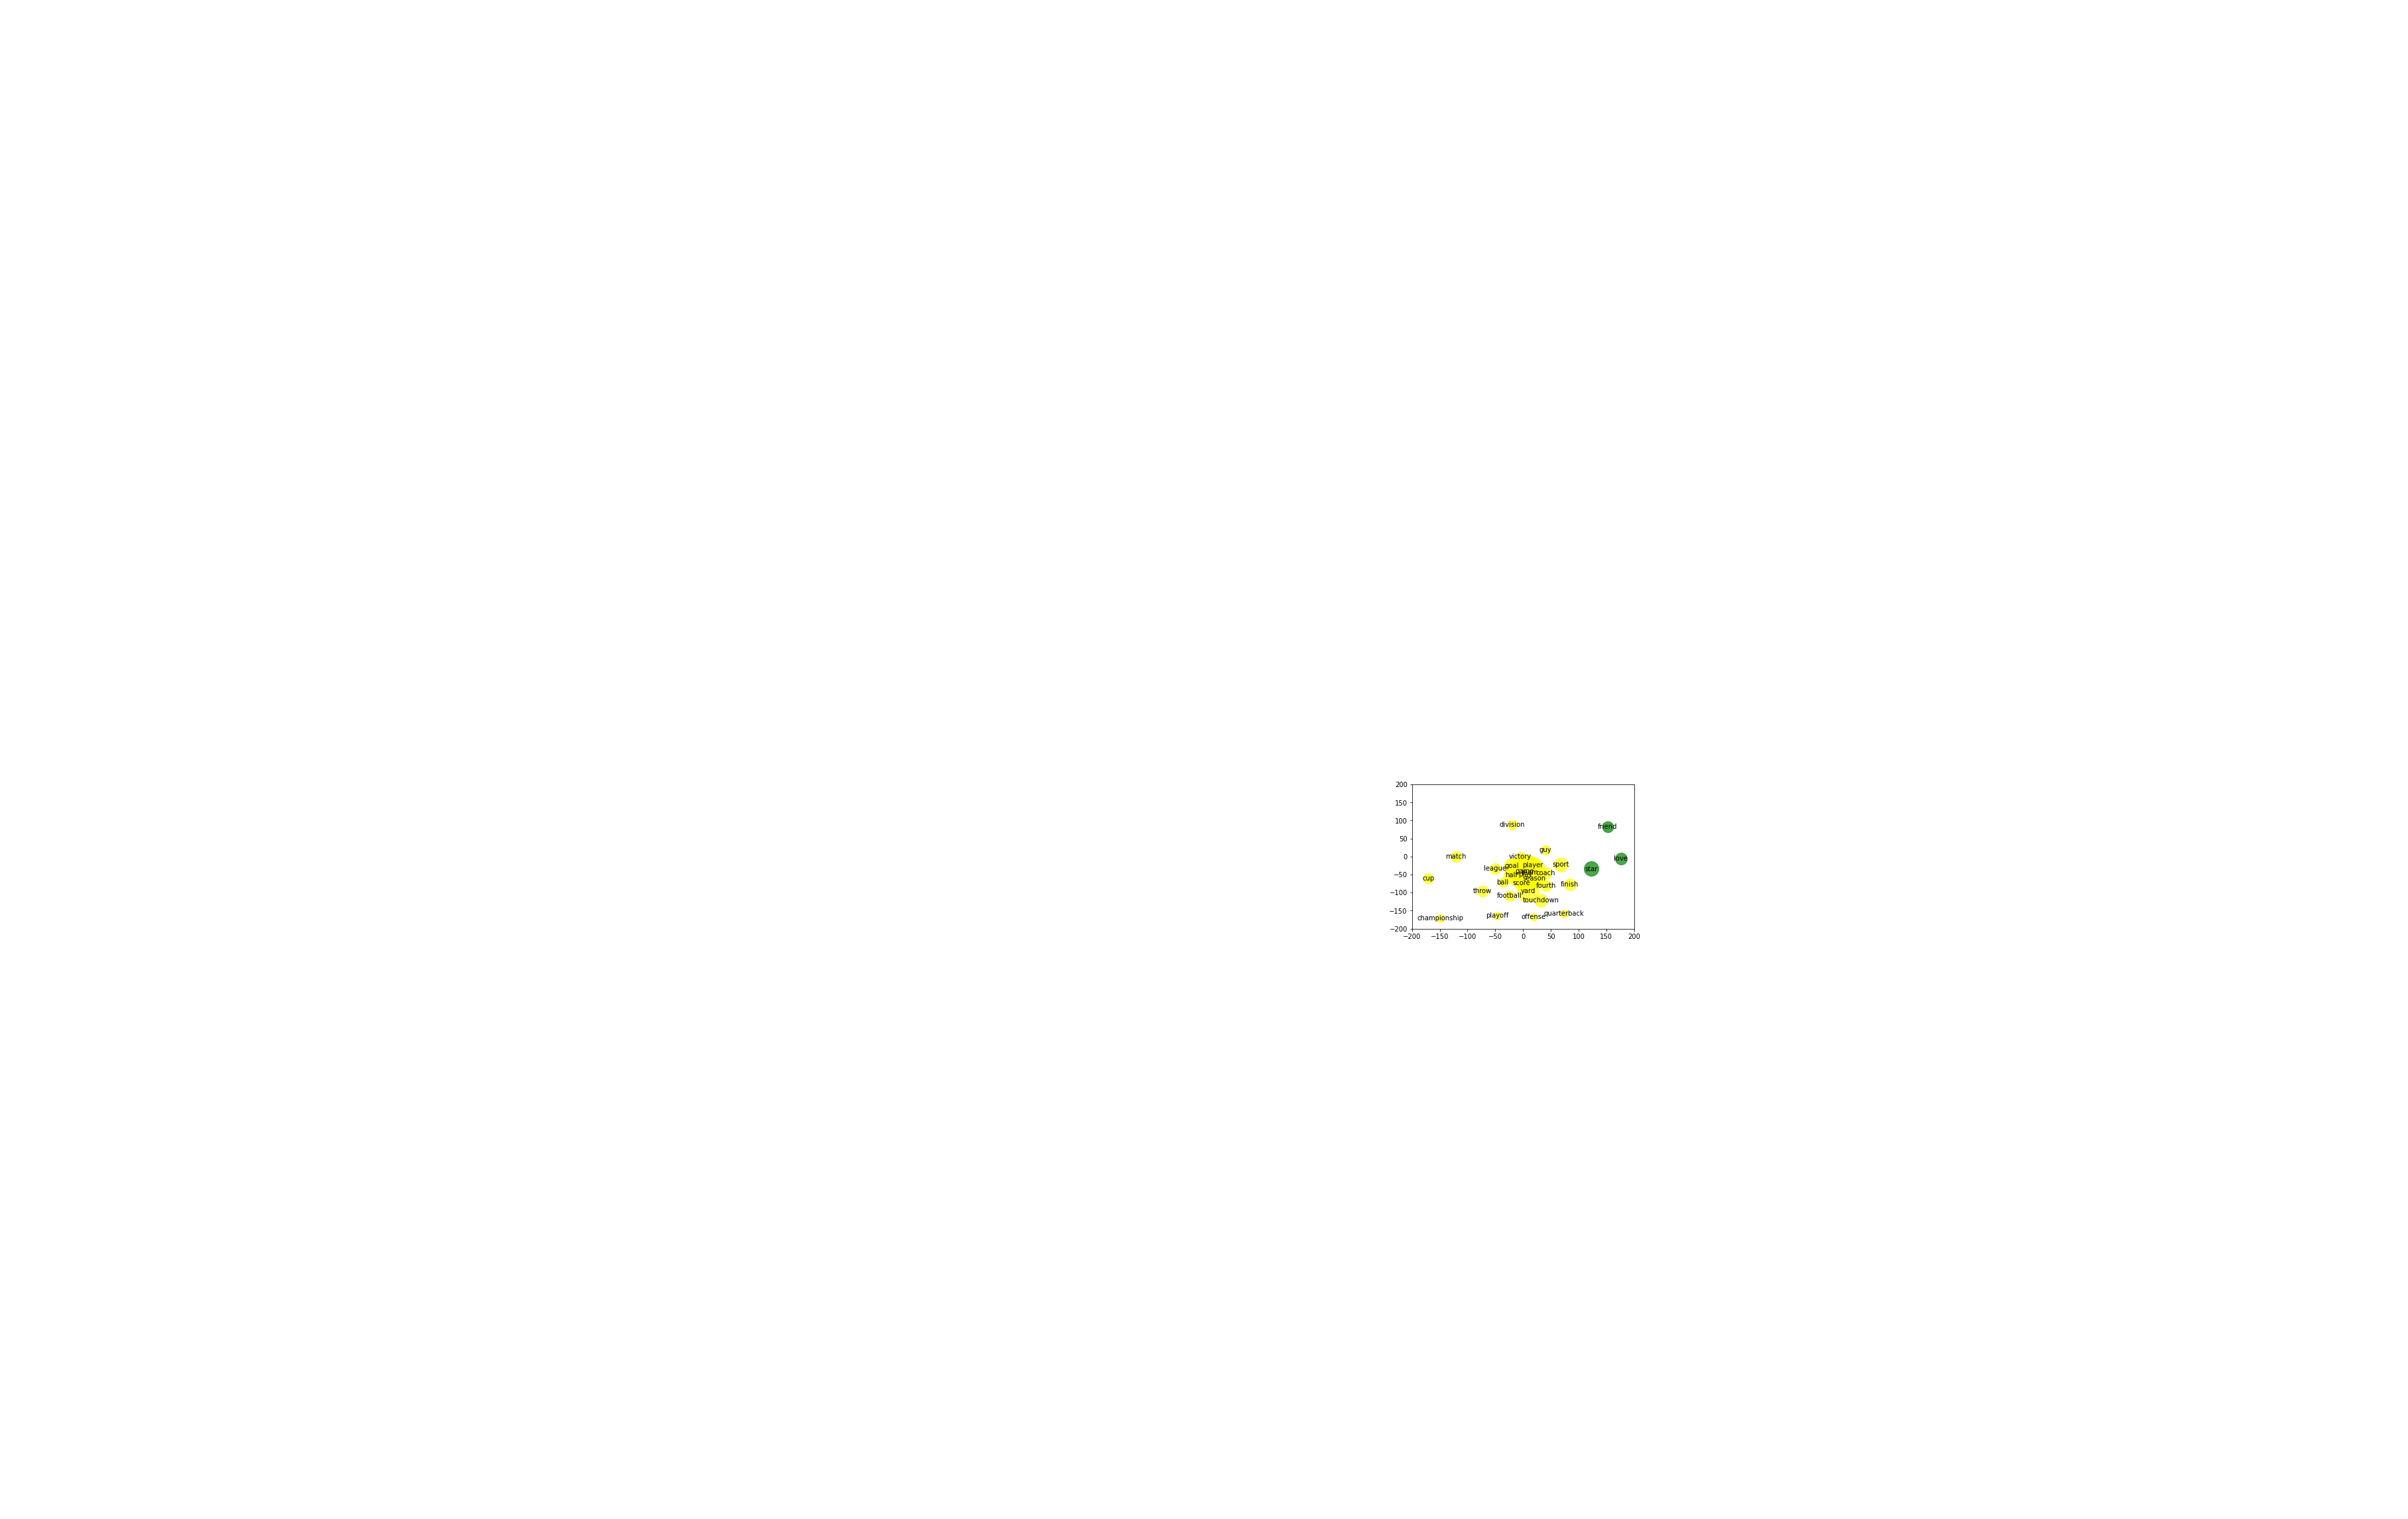

In [26]:
fig, ax = plt.subplots()#figsize=(50,50))
#fig.tight_layout()

idx = word_categories

# Set range
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)

# List of colors
colors = ['green', 'orange', 'red', 'blue', 'yellow', 'brown', 'violet', 'grey']

# Plot all words
for word, idx_, vec in zip(words, idx, Map):
    x = vec[0]
    y = vec[1]
    ms = scaler.transform(count_total[word])
    ax.plot(x, y, marker='o', ms=ms, c=colors[idx_], alpha=0.7, linestyle='none')
    plt.annotate(word, (vec[0], vec[1]), ha='center', va='center', size=10)

In [28]:
import imageio
import io

def plot_for_offset(Map):
    
    if False:
        #################  K Means  #################
        # Set number of clusters
        n_clusters = 7

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(Map)
        idx = kmeans.fit_predict(Map)
        kmeans.score(Map)
    else:
        ########### Categories by word count per category ############
        idx = word_categories
    
    #################  Plot  #########################

    fig, ax = plt.subplots(figsize=(12,12))
    fig.tight_layout()
    
    # Set range
    ax.set_xlim(-2000,2000)
    ax.set_ylim(-2000,2000)
    
    # List of colors
    colors = ['green', 'orange', 'red', 'blue', 'yellow', 'brown', 'violet', 'grey']

    # Plot all words
    for word, idx_, vec in zip(words, idx, Map):
        x = vec[0]
        y = vec[1]
        ms = scaler.transform(count_total[word])
        ax.plot(x, y, marker='o', ms=ms, c=colors[idx_], alpha=0.7, linestyle='none')
        plt.annotate(word, (vec[0], vec[1]), ha='center', va='center', size=10)
                
    # Used to return the plot as an image rray
    plt.close(fig)
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw')
    io_buf.seek(0)
    image = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()

    return image

start_time = time()
kwargs_write = {'fps':1.0, 'quantizer':'nq'}

if False:
    map_hist_less = []
    count = 0
    for m in Map_History:
        if count%10 == 0:
            map_hist_less.append(m)
        count+=1
    imageio.mimsave('./map.gif', [plot_for_offset(m) for m in map_hist_less], fps=1)
else:
    imageio.mimsave('./map.gif', [plot_for_offset(m) for m in Map_History], fps=30)
    
print('Plotting took {:.2f}m'.format((time()-start_time)/60))

Plotting took 45.20m


In [ ]:
# for output config: 
import bokeh.io 
bokeh.io.reset_output()
# shows output in notebook:
bokeh.io.output_notebook()

from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show

#output_file("label.html", title="label.py example")

source = ColumnDataSource(data=dict(height=[66, 71, 72, 68, 58, 62],
                                    weight=[165, 189, 220, 141, 260, 174],
                                    names=['Mark', 'Amir', 'Matt', 'Greg',
                                           'Owen', 'Juan']))

p = figure(title='Dist. of 10th Grade Students at Lee High',
           x_range=Range1d(140, 275))
p.scatter(x='weight', y='height', radius=2, source=source)
p.xaxis[0].axis_label = 'Weight (lbs)'
p.yaxis[0].axis_label = 'Height (in)'

labels = LabelSet(x='weight', y='height', text='names', level='glyph',
                  text_font_size='20pt',
              x_offset=0, y_offset=0, source=source, render_mode='canvas')

citation = Label(x=70, y=70, x_units='screen', y_units='screen',
                 text='Collected by Luke C. 2016-04-01', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=1.0)

p.add_layout(labels)
p.add_layout(citation)

show(p)
